In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import torch
import h5py
from itertools import product

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [3, 1]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Settings

We set the batch size and the discretization scheme of the data

In [2]:
# batch size
nbatch = 6000
# size of image NxN
N = 3
# discrete values per pixel
M = 2
# Image data to read (as hdf5)
file_name = "../data/QG_train_normalized_N3_M2_bilinear_xl"
#file_name = "QG_train_normalized_N3_M2_bilinear_xl"

# Layers for the quantum model
n_layers = 30

# Number of qubits per pixel
qM = int(np.log2(M))

# Maximal integer value of unnormalized images
nM = M - 1

# total number of qubits
num_qubits = int(N**2 * qM)
# Number of basis states
num_discrete_values = 2**num_qubits

reg = 0.000001

## Data

First we read in the data

In [3]:
f = h5py.File(file_name,"r")
x_train = f.get('X')
y_train = f.get('y')

lets check the two classes

(-0.5, 2.5, 2.5, -0.5)

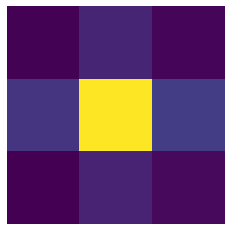

In [4]:
plt.imshow(np.mean(x_train[y_train[:]==1],axis=0),norm=matplotlib.colors.LogNorm())
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

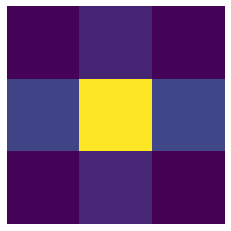

In [5]:
plt.imshow(np.mean(x_train[y_train[:]==0],axis=0),norm=matplotlib.colors.LogNorm())
plt.axis('off')

lets look at some examples

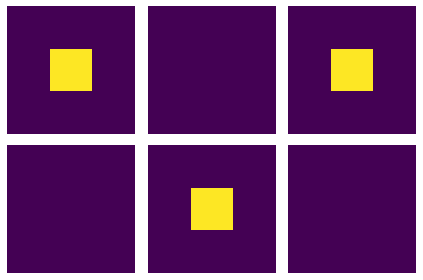

In [6]:
fig, ax = plt.subplots(2, 3)
for i,j in product(range(2),range(3)):
    num = np.random.randint(0,x_train.shape[0])
    ax[i,j].imshow(x_train[num])
    ax[i,j].axis('off')
fig.tight_layout()

Now we grab the data for one class and close the file.
This is the data we will be working with and which we wish to model.

In [7]:
data = x_train[y_train[:]==1]
f.close()
data.shape

(49962, 3, 3)

We can use the mean to check how the distribution looks like on average

In [8]:
mean_data = np.mean(data,axis=0)

## Utillity functions

We will use some utility functions during the training:

In [9]:
def int_to_bin_list(num, bits):
    """Function to convert an integer to a list of 0s and 1s representing its binary

    Args:
        num (int): The integer to convert 
        bits (int): The number of bits for binary representaion

    Returns:
        list[int]: List of 0s and 1s representing the binary with 'bits' bits
    """
    return [(num>>k)&1 for k in range(0,bits)][::-1]

In [10]:
def convert_dim_to_integer(arr, dim):
    """function to concat a single dimension of an array of 0s and 1s to integeers

    Args:
        arry (list(int)): The integer array to use
        dim (int): The dimension to cancat

    Returns:
        list[int]: list with dimension dim removed an concated to integers
    """
    num_values = 2 ** arr.shape[dim]
    arr = torch.flip(arr,(1,))
    integer_array = np.sum(arr * (2 ** np.arange(arr.shape[dim])), axis=-1)

    return torch.tensor(integer_array)

In [11]:
def normalize_image(img):
    """normalize an image given as 2d array of integers to [0,1]

    Args:
        img (list(int)): 2d int array with maximum value nM

    Returns:
        list[int]: Normalized image
    """
    return img / nM

In [12]:
def basis_array_to_img(basis_array):
    """Convert a basis state, that is a 1D array of 0s and 1s to a NxN image

    Args:
        basis_array (list[int]): 1D int array of length num_qubits

    Returns:
        list[int]: 2d image array
    """
    basis_array = basis_array.reshape(N,N,qM)
    return normalize_image(convert_dim_to_integer(basis_array,2))

In [13]:
def batch_basis_array_to_img(batch_basis_array):
    """Convert a batch of basis states, that is a 1D arrays of 0s and 1s to a NxN images

    Args:
        batch_basis_array (list[int]): batch of 1D int arrays of length num_qubits

    Returns:
        list[int]: batch of 2d image arrays
    """
    batch_basis_array = batch_basis_array.reshape(batch_basis_array.shape[0],N,N,qM)
    return normalize_image(convert_dim_to_integer(batch_basis_array,3))

In [14]:
def tensor_to_int(tensor):
    """Convert a pytorch tensor to integer values

    Args:
        tensor (torch.tensor): tensor of 0s and 1s
    Returns:
        torch.tensor: tensor containing integer values
    """
    tensor = tensor.long()
    num_columns = tensor.size(1)
    weights = 2 ** torch.arange(num_columns - 1, -1, -1)
    int_values = torch.sum(tensor * weights, dim=1)
    
    return int_values

In [15]:
from IPython.display import clear_output

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_training_progress(epoch, samples_tuple, mean_gen_image):
    """Plot some training quantities
    
    Args:
        epoch (int): step to plot
        samples_tuble (Tuple[torch.tensor[int])): A tuple of different samples of the basis states to use to evaluate the loss function
        mean_gen_image (toch.tensor): 2D tensor representing the mean of the generated images
    """

    clear_output(wait=True)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    fig.tight_layout(pad=10.0)

    # Generator Loss
    ax3.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax3.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax3.legend(loc="best", fontsize=16)
    ax3.set_xlabel("epoch", fontsize=16)
    ax3.set_ylabel("Loss", fontsize=16)

    # KL divergence
    ax2.plot(entropies)
    ax2.set_xlabel("epoch", fontsize=18)
    ax2.set_ylabel("KL divergence", fontsize=18)
    ax2.set_yscale("log")
    
    # mean generator image
    im = ax1.imshow(mean_gen_image, norm=matplotlib.colors.LogNorm())
    plt.colorbar(im,ax=ax1)
    ax1.title.set_text('Mean of generated images')

    
    # mean data image
    im2 = ax4.imshow(mean_data, norm=matplotlib.colors.LogNorm())
    plt.colorbar(im2,ax=ax4)
    ax2.title.set_text('Mean of data images')
    
    # mean square error
    ax5.plot(mses)
    ax5.set_xlabel("epoch", fontsize=18)
    ax5.set_ylabel("MSE of mean images", fontsize=18)
    ax5.set_yscale("log")
    
    # plt.savefig(f"imgs/{epoch}.png")
    
    plt.show()

In [16]:
def iterate_minibatches(data, batch_size):
    """generator of mini batches of specified batch size

    Args:
        data (torch.tensor): dataset of arbitary dimension
        
    Yields:
        torch.tensor: Batch of batch_size 
    """
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

# Model

Now we are ready to build our models

## Generator circuits

We build a simple circuit for the generator which basically consists of a strongly entangling layer.
Note that I pass an input to the circuit becauset this is required to build a pytorch layer from the circuit. **However we dont use this input!**

Increasing cachesize is required for larger circuits

In [17]:
dev = qml.device("default.qubit.torch", wires=num_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop", cachesize=1000000)
def circuit(inputs, weights):
    for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.probs()

If we want to sample from the generator we define a circuit with the respective measurements

In [18]:
dev_sample = qml.device("default.qubit", wires=num_qubits, shots=nbatch)

@qml.qnode(dev_sample, interface="torch")
def circuit_sample(inputs, weights):
    for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.sample()

## Hybrid model building

The weight shapes are determined from the number of layers and number of qubits. This format is expected by the strongly entangling layer.

In [19]:
weight_shapes = {"weights": (n_layers, num_qubits,3)}
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

Here we define the discriminator as simple feed forward neural network.

In [20]:
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 50)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear1 = nn.Linear(50, 20)
        self.linear2 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

    def forward(self, inputs):
        x = self.flatten(inputs)
        x = self.linear_input(x)
        x = self.leaky_relu(x)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [21]:
generator = qlayer
discriminator = Discriminator(N**2)

# Training

For evaluation we want to compute the KL divergence. To do so, we need to obtain the probabilities for every basis state occuring in the dataset.

I do that by casting the input images to integers and then determin how often each of these integers occurs in the dataset.

In [22]:
prob_distr = data.reshape(-1,N**2)
prob_distr_nums = convert_dim_to_integer(torch.tensor(prob_distr),1)
vals, counts = np.unique(prob_distr_nums, return_counts=True)
counts_full = np.zeros(num_discrete_values)
counts_full[vals.astype(int)] = counts
counts_full_norm = counts_full / prob_distr_nums.shape[0]

Now we can come to the training.
We specify the training parameters ad

In [23]:
from torch.optim import Adam

lr = 0.001  # learning rate
b1 = 0.6  # first momentum 
b2 = 0.999  # second momentum 
n_epochs = 500 # number epochs
decayRate = 0.9992 # decay rate for lr decay
weight_decay = 0 # adam weight decay

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=weight_decay, amsgrad=True)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=weight_decay, amsgrad=True
)


gen_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=decayRate)
disc_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=decayRate)

In [24]:
def loss_true(inputs, w):
    loss = w * torch.log(inputs + reg)
    return -torch.sum(loss)

def loss_false(inputs, w):
    loss = w * torch.log(1 - inputs)
    return -torch.sum(loss)

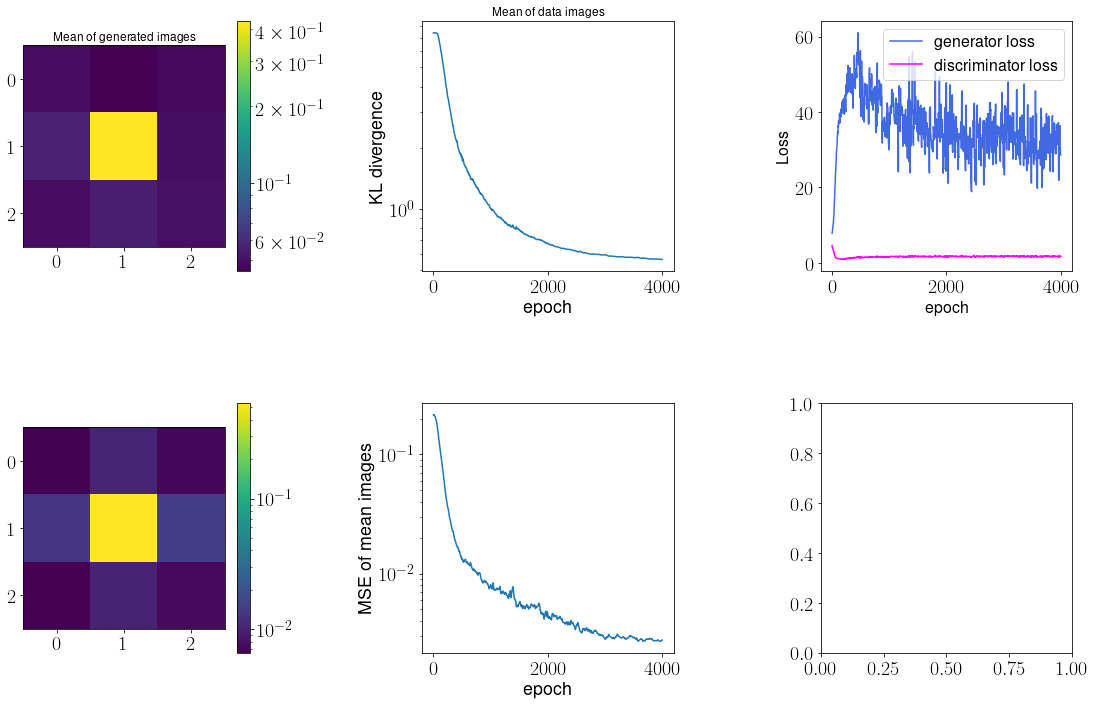

Fit in 9001.10 sec


In [25]:
import time
from scipy.stats import multivariate_normal, entropy

#torch.nn.init.uniform_(list(generator.parameters())[0], a=-np.pi, b=np.pi)
torch.nn.init.uniform_(list(generator.parameters())[0], a=-0.1, b=0.1)



data = torch.tensor(data, requires_grad=False)

generator_loss_values = []
discriminator_loss_values = []
entropies = []
mses = []

start = time.time()
for epoch in range(n_epochs):

    #samples = circuit_sample(1, list(generator.parameters())[0].detach())
    #samples = torch.tensor(np.random.randint(0,16, size=(nbatch,)), dtype=torch.float).reshape(nbatch,1)
    samples = torch.tensor(np.random.randint(0,M,size=(nbatch,num_qubits)), dtype=torch.float)
    samples_idx = convert_dim_to_integer(samples,1)
    samples_img = batch_basis_array_to_img(samples)
    
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=nbatch)):
 
        # discriminator values
        disc_value = discriminator(samples_img.float())
    
        # gen dist
        gen_dist = generator(torch.tensor([]))
        
        # Train generator
        generator_optimizer.zero_grad()
        #generator_loss = adversarial_loss(disc_value.detach().reshape(-1), valid, gen_dist[samples_idx.long().reshape(-1)])
        generator_loss = loss_true(disc_value.detach().reshape(-1), gen_dist[samples_idx.long().reshape(-1)])
        
        # store for plotting
        generator_loss_values.append(generator_loss.detach().item())

        generator_loss.backward(retain_graph=True)
        generator_optimizer.step()

        # Train Discriminator
        discriminator_optimizer.zero_grad()
     
        real_disc_vals = discriminator(Xbatch.float())
    
        #real_loss = adversarial_loss(real_disc_vals.reshape(-1), valid, torch.tensor(np.ones(nbatch)*1/nbatch, requires_grad=False))
        real_loss = loss_true(real_disc_vals.reshape(-1), torch.tensor(np.ones(nbatch)*1/nbatch, requires_grad=False))
        #fake_loss = adversarial_loss(disc_value.reshape(-1), fake, gen_dist.detach()[samples_idx.long().reshape(-1)])
        fake_loss = loss_false(disc_value.reshape(-1), gen_dist.detach()[samples_idx.long().reshape(-1)])
        discriminator_loss = (real_loss + fake_loss) / 2    
        
        # Store for plotting
        discriminator_loss_values.append(discriminator_loss.detach().item())
    
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        mean_gen_image = torch.sum(gen_dist.detach().squeeze().reshape(-1,1,1)*batch_basis_array_to_img(torch.tensor([int_to_bin_list(x,num_qubits) for x in range(2**num_qubits)])),0)
        
        
        entropy_val = entropy(gen_dist.detach()+0.000001, counts_full_norm+0.000001)
        entropies.append(entropy_val)
        
        mse_val = np.mean((mean_gen_image.numpy()-mean_data)**2)
        mses.append(mse_val)
        
        gen_lr_scheduler.step()
        disc_lr_scheduler.step()

        plot_training_progress(epoch, (samples,),mean_gen_image)
        
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

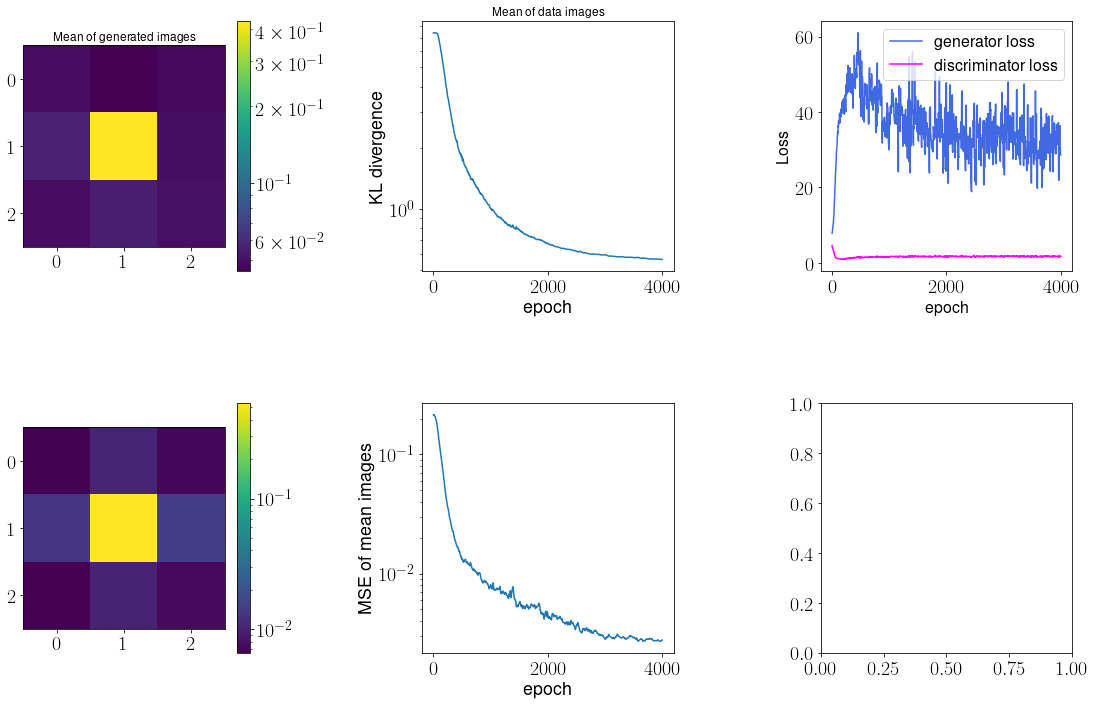

In [26]:
plot_training_progress(epoch, (samples,),mean_gen_image)

In [27]:
torch.sum(mean_gen_image)

tensor(0.8306)

In [28]:
basis_array_to_img(circuit_sample(1, list(generator.parameters())[0].detach())[0])

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])

In [29]:
batch_basis_array_to_img(torch.tensor([int_to_bin_list(x,num_qubits) for x in range(2**num_qubits)])).shape

torch.Size([512, 3, 3])

In [30]:
circuit(1, list(generator.parameters())[0].detach())

tensor([5.0404e-01, 4.0984e-03, 7.8192e-04, 2.2109e-04, 1.1788e-03, 4.4624e-05,
        8.7489e-04, 1.1429e-03, 2.5373e-04, 5.2495e-05, 9.6460e-04, 1.1636e-06,
        1.3137e-03, 1.9233e-04, 3.9190e-04, 1.6686e-04, 3.5084e-01, 2.7869e-03,
        3.3127e-04, 1.6120e-04, 2.5450e-03, 1.6627e-05, 6.4173e-04, 1.5816e-04,
        6.6953e-03, 1.7835e-04, 8.3955e-05, 9.2453e-06, 6.1228e-04, 3.2750e-06,
        2.7570e-04, 1.2862e-05, 1.6155e-03, 3.4226e-04, 2.9544e-05, 4.6366e-04,
        2.6211e-05, 6.3156e-05, 6.1009e-05, 5.4649e-04, 1.2867e-03, 5.8188e-05,
        1.9140e-04, 1.5141e-04, 3.4941e-05, 4.1442e-04, 1.0439e-05, 1.4219e-04,
        1.0868e-02, 4.0396e-05, 7.9219e-04, 2.6052e-04, 4.6345e-05, 1.1618e-04,
        1.3480e-04, 2.7791e-04, 7.3994e-04, 9.5953e-07, 5.8753e-06, 1.2523e-04,
        1.3677e-04, 3.7458e-05, 3.1373e-05, 2.9750e-05, 2.7080e-04, 5.5257e-04,
        5.5952e-04, 1.5889e-05, 1.4872e-03, 2.7554e-05, 1.1697e-04, 6.4727e-05,
        2.9082e-04, 7.5607e-05, 2.1439e-

In [31]:
counts_full_norm

tensor([4.01044794e-01, 5.94451783e-03, 7.44565870e-03, 6.00456347e-05,
        5.28401585e-03, 4.00304231e-05, 4.00304231e-05, 0.00000000e+00,
        1.11885033e-02, 8.00608462e-05, 2.20167327e-04, 0.00000000e+00,
        4.00304231e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.24818862e-01, 1.10083664e-03, 2.08158200e-03, 0.00000000e+00,
        1.04079100e-03, 2.00152116e-05, 2.00152116e-05, 0.00000000e+00,
        2.60197750e-03, 2.00152116e-05, 2.00152116e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.01477123e-02, 2.00152116e-05, 1.00076058e-04, 0.00000000e+00,
        6.00456347e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00076058e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.34177975e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [32]:
circuit(1, list(generator.parameters())[0].detach())[16]

tensor(0.3508, dtype=torch.float64)

In [33]:
np.argmax(counts_full_norm)

16

In [34]:
circuit(1, list(generator.parameters())[0].detach())

tensor([5.0404e-01, 4.0984e-03, 7.8192e-04, 2.2109e-04, 1.1788e-03, 4.4624e-05,
        8.7489e-04, 1.1429e-03, 2.5373e-04, 5.2495e-05, 9.6460e-04, 1.1636e-06,
        1.3137e-03, 1.9233e-04, 3.9190e-04, 1.6686e-04, 3.5084e-01, 2.7869e-03,
        3.3127e-04, 1.6120e-04, 2.5450e-03, 1.6627e-05, 6.4173e-04, 1.5816e-04,
        6.6953e-03, 1.7835e-04, 8.3955e-05, 9.2453e-06, 6.1228e-04, 3.2750e-06,
        2.7570e-04, 1.2862e-05, 1.6155e-03, 3.4226e-04, 2.9544e-05, 4.6366e-04,
        2.6211e-05, 6.3156e-05, 6.1009e-05, 5.4649e-04, 1.2867e-03, 5.8188e-05,
        1.9140e-04, 1.5141e-04, 3.4941e-05, 4.1442e-04, 1.0439e-05, 1.4219e-04,
        1.0868e-02, 4.0396e-05, 7.9219e-04, 2.6052e-04, 4.6345e-05, 1.1618e-04,
        1.3480e-04, 2.7791e-04, 7.3994e-04, 9.5953e-07, 5.8753e-06, 1.2523e-04,
        1.3677e-04, 3.7458e-05, 3.1373e-05, 2.9750e-05, 2.7080e-04, 5.5257e-04,
        5.5952e-04, 1.5889e-05, 1.4872e-03, 2.7554e-05, 1.1697e-04, 6.4727e-05,
        2.9082e-04, 7.5607e-05, 2.1439e-